# LAB4 - TensorFlow Lite
ver: 3

Przedmiot: _Sztuczna Inteligencja w Systemach Informatycznych_

Autor: Tomasz Szydło

kontakt: tszydlo@agh.edu.pl


## Wprowadzenie

Celem zajęć jest analiza działania konwersji sieci neuronowych do postaci możliwej do uruchomienia na urządzeniach o ograniczonych zasobach. W czasie zajęć będzie wykorzystywany zbiór Fashion MNIST, który zawiera 60000 obrazków w 10 kategoriach:

https://github.com/zalandoresearch/fashion-mnist


https://www.tensorflow.org/datasets/catalog/fashion_mnist


### Środowisko pracy - Google Codelab

https://codelabs.developers.google.com/?cat=Machine+Learning



In [1]:
try:
    %tensorflow_version 2.x
except:
    pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, AveragePooling2D, MaxPooling2D

from tensorflow.keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
import pathlib

import time

print(tf.__version__)

2.15.0


Przygotuj zbiór testowy. Zbiór fashion_mnist nie posiada słownych opisów klas.

In [3]:
nb_classes = 10
class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#(X_train, y_train), (X_test, y_test) = mnist.load_data()
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

4422102/4422102 [==============================] - 0s 0us/step
X_train original shape (60000, 28, 28)
y_train original shape (60000,)


Wypisz ilość elementów w zbiorze uczącym i testowym.

In [4]:
print(X_test)
print(X_train)

print(f'Len of X_test: {len(list(X_test))}')
print(f'Len of X_train: {len(list(X_train))}')

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ...

**TODO** Zmień poniższy kod tak by wyświetlić 10 przykładowych obrazków - po jednym z każdej klasy.

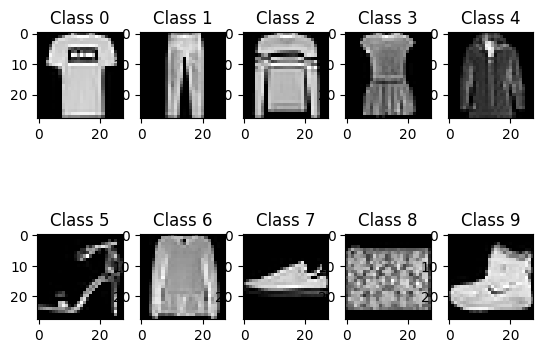

In [5]:
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[y_train == i][0], cmap='gray', interpolation='none')
    plt.title(f'Class {y_train[y_train == i][0]}')

Sieć neuronowa przyjmuje na wejściu obrazek z jednym kanałem - poziomem jasności, więc konieczne jest przekształcenie danych wejściowych, aby każdy obraz 28 x 28 stał się macierzą 28 x 28 x 1.

Skalujemy również dane wejściowe w zakresie [0–1] zamiast [0–255]

In [6]:
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

print(nb_classes)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)
10


Zmodyfikuj macierze wyjść korzystając z techniki One Hot Encoding, tj.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
```
itp.

In [7]:
Y_train = to_categorical(y_train, num_classes=len(np.unique(y_train)))
Y_test = to_categorical(y_test, num_classes=len(np.unique(y_train)))

Wielowarstwowa sieć konwolucyjna do klasyfikacji ubrań.

In [8]:
model = Sequential([
    Conv2D(16, 3, activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(),
    Conv2D(32, 3, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 flatten (Flatten)           (None, 3872)              0         
                                                                 
 dense (Dense)               (None, 64)                247872    
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                        

W celu skrócenia czasu uczenia sieci wskazane jest użycie GPU.

In [10]:
model.fit(X_train, Y_train,
          batch_size=32, epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/10
1875/1875 [==============================] - 18s 5ms/step - loss: 0.4456 - accuracy: 0.8385 - val_loss: 0.3379 - val_accuracy: 0.8803
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2934 - accuracy: 0.8944 - val_loss: 0.2856 - val_accuracy: 0.8955
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2435 - accuracy: 0.9116 - val_loss: 0.2633 - val_accuracy: 0.9023
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2101 - accuracy: 0.9237 - val_loss: 0.2547 - val_accuracy: 0.9077
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1845 - accuracy: 0.9329 - val_loss: 0.2496 - val_accuracy: 0.9107
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1601 - accuracy: 0.9413 - val_loss: 0.2373 - val_accuracy: 0.9179
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1402 - accuracy: 0.9489 - val_loss: 0.2337 - val_accuracy

# Zapisywanie NN

Szczegółowe informacje dotyczące zapisywania modeli TensorFlow dostępne pod linkiem:

https://www.tensorflow.org/tutorials/keras/save_and_load

In [11]:
export_dir = 'saved_model'
model.save(export_dir)

Po zapisaniu modelu należy kliknąć "Refresh" po lewej stronie w zakładce "Files". W katalogu "saved_model" znajduje się zapisany model.

# Export do TFLite

Narzędzie `TFLiteConverter` zostanie wykorzystane do konwersji modelu NN do formatu akceptowanego przez TFLite tzn. `flat protocol buffers`.

https://www.tensorflow.org/lite/guide/get_started#2_convert_the_model_format

Wygenerowany model `"model-base.tflite"` operuje na wagach typu `float32`.

In [12]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

with open("model-base.tflite", "wb") as f:
    f.write(tflite_model)

Po zapisaniu modelu należy kliknąć "Refresh" po lewej stronie w zakładce "Files".

Kolejnym krokiem jest kwantyzacja wag modelu z 32 bitowych liczb rzeczywistych do liczb 8 bitowych. Proces kwantyzacji jest uruchamiany na gotowym, wyuczonym modelu. Należy wybrać profil optymaliacji `tf.lite.Optimize.DEFAULT`.



In [13]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

#TODO ustaw odpowiedni rodzaj optymalizacji sieci neuronowej
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open("model-quant.tflite", "wb") as f:
    f.write(tflite_model)

Po zapisaniu modelu należy kliknąć "Refresh" po lewej stronie w zakładce "Files".

In [19]:
# funkcja testujaca model z wykorzystaniem interpretera TFLite
# TODO zmodyfikuj funkcje tak by zwracala (accuracy, latency)
from time import perf_counter


def test_model_accuracy(tflite_model):
    # Load TFLite model and allocate tensors.
    start = perf_counter()
    interpreter = tf.lite.Interpreter(model_path=tflite_model)
    interpreter.allocate_tensors()

    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    acc_count = 0

    for img, label in zip(X_test, y_test):
        interpreter.set_tensor(input_index, [img])

        interpreter.invoke()

        prediction = interpreter.get_tensor(output_index)
        label_is = np.argmax(prediction, axis=-1)[0]
        label_should_be = label
        if label_is == label_should_be:
            acc_count += 1

        print("Label is {} should be {}.".format(label_is, label_should_be))

    end = perf_counter()

    accuracy = acc_count / len(y_test)
    latency = end - start

    return accuracy, latency

In [20]:
model_base_acc, model_base_time = test_model_accuracy("model-base.tflite")
print(model_base_acc)

model_quant_acc, model_quant_time = test_model_accuracy("model-quant.tflite")
print(model_quant_acc)

0.9175
0.9178


Model base accuracy: 0.9175
Model quant accuracy: 0.9178


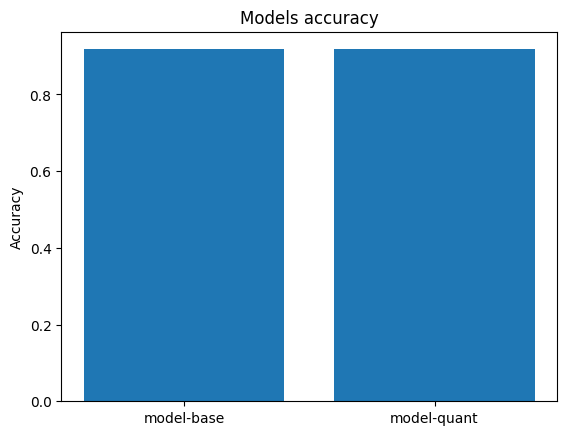

In [21]:
# porównaj dokladnosc wynikowych modeli TFLite

# TODO wyniki przedstaw na wykresie słupkowym (jeden slupek dla model-base, a drugi dla model-quant)
print(f'Model base accuracy: {model_base_acc}')
print(f'Model quant accuracy: {model_quant_acc}')

plt.bar(['model-base', 'model-quant'], [model_base_acc, model_quant_acc])
plt.ylabel('Accuracy')
plt.title('Models accuracy')
plt.show()

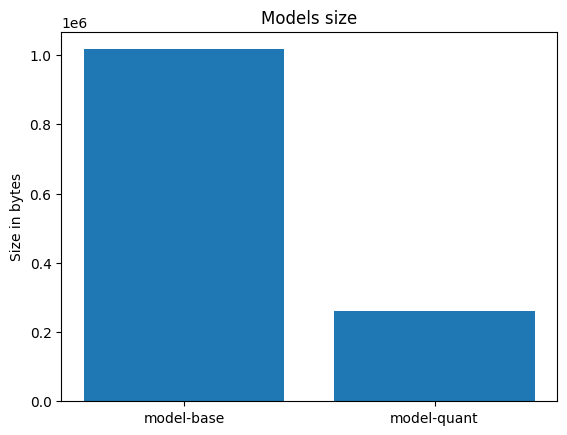

In [22]:
# porównaj rozmiar wynikowych modeli TFLite

# TODO wyniki przedstaw na wykresie słupkowym (jeden slupek dla model-base, a drugi dla model-quant)
plt.bar(['model-base', 'model-quant'],
        [pathlib.Path('model-base.tflite').stat().st_size, pathlib.Path('model-quant.tflite').stat().st_size])
plt.ylabel('Size in bytes')
plt.title('Models size')
plt.show()

Model base time: 0.9000262069999962
Model quant time: 0.4727648379999664


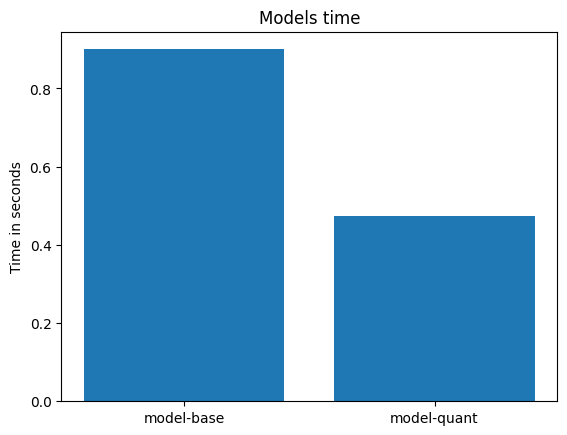

In [23]:
# porównaj czas dzialania wynikowych modeli TFLite

# TODO wyniki przedstaw na wykresie słupkowym (jeden slupek dla model-base, a drugi dla model-quant)
print(f'Model base time: {model_base_time}')
print(f'Model quant time: {model_quant_time}')

plt.bar(['model-base', 'model-quant'], [model_base_time, model_quant_time])
plt.ylabel('Time in seconds')
plt.title('Models time')
plt.show()

 # Wnioski

**TODO** Przedstaw wnioski z przeprowadzonych eksperymentów

Wnioski:
- Dokładności obu modeli są bardzo podobne, można powiedzieć, że są identyczne.
- Rozmiar modelu model-quant jest znacznie mniejszy niż modelu model-base.
- Czas działania modelu model-quant jest mniejszy niż modelu model-base.

**TODO** Dlaczego czasy działania modeli są różne?

Czasy działania modeli są różne, ponieważ model model-quant jest zoptymalizowany, co pozwala na szybsze działanie modelu. Również model model-quant jest mniejszy, co pozwala na szybsze działanie modelu.